## Utilities

In [1]:
import re, glob, math
from collections import defaultdict
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from pathlib import Path
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt

from data.preprocessing.preprocess import preprocess_plateaus  # preprocessor
from experiments_xy import (
    collect_dataset_from_combined,   # builds X,y,groups from *_combined.npy
    build_X,                         # shapes features by mode name
)

from utils import (
    _expand_combined_files,
    _bin_series,
    nominal_angle_from_path,
    nominal_from_group,
    split_one_plateau_per_angle_test,
    _find_bin_dirs,
    _load_metrics_for_bin,
    _plot_line,
    angle_deg,
    angle_err_deg,
    mag,
    full_plot_suite
)


In [2]:


# --- EDIT THESE ---
COMBINED_DIR = Path("data/preprocessing/P3_combined")       # where *_combined.npy live
RESULTS_ROOT = Path("results_feat/P3_angle")                # where experiments_xy.py wrote outputs
BIN_SEC      = 0.050                                        # must match training
RMS_WIN      = 100                                          # must match training
MODEL_MODE   = "rms_matrix"                                 # which feature mode to load/evaluate
RANDOM_STATE = 42



# Predictions

In [3]:
# Build dataset (two plateaus per *_combined.npy)
buckets = collect_dataset_from_combined(
    COMBINED_DIR,
    bin_sec=BIN_SEC,
    include_angle_target=True,
    rms_win_samples=RMS_WIN,
    modes=(MODEL_MODE,),
)

# Pick the bin_len we trained with (auto-pick single one)
assert len(buckets) >= 1, "No data loaded."
bin_len = list(buckets.keys())[0] if 'BIN_FOLDER' not in globals() else int(str(BIN_FOLDER).split('_')[-1])

X = buckets[bin_len]["X"]
y = buckets[bin_len]["y"]           # columns: Fx, Fy, Angle
groups = buckets[bin_len]["groups"]

print("X:", X.shape, "y:", y.shape, "unique groups:", len(np.unique(groups)))

# Same split as training: hold out one plateau per nominal angle
train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, rng=RANDOM_STATE)
X_tr, y_tr, groups_tr = X[train_idx], y[train_idx], groups[train_idx]
X_te, y_te, groups_te = X[test_idx],  y[test_idx],  groups[test_idx]
print(f"Train: {X_tr.shape}, Test: {X_te.shape}, Held-out groups: {len(set(test_groups))}")

# Resolve results folder
if 'BIN_FOLDER' in globals():
    out_dir = BIN_FOLDER
else:
    out_dir = next((p for p in sorted(RESULTS_ROOT.glob(f"bin_{bin_len}")) if p.is_dir()), None)
    assert out_dir is not None, f"No results folder found for bin_{bin_len} under {RESULTS_ROOT}"

print("Using results folder:", out_dir)

# Load model + optional y_scaler
model_path = out_dir / f"ridge_{MODEL_MODE}.joblib"
yscaler_path = out_dir / "y_scaler.joblib"
model = joblib.load(model_path)
y_scaler = joblib.load(yscaler_path) if yscaler_path.exists() else None
print("Loaded:", model_path.name, "| y_scaler:", yscaler_path.exists())


[PATH] combined-dir: data/preprocessing/P3_combined -> resolved: /Users/juliahagen/IntMS_EEG/data/preprocessing/P3_combined
[PATH] matched files: 11
[LOAD] bin_len=512 (~0.050s): X=(6434, 16), y=(6434, 3), groups=22
[DONE] processed files: 11/11
X: (6434, 16) y: (6434, 3) unique groups: 22
Train: (5558, 16), Test: (876, 16), Held-out groups: 3
Using results folder: results_feat/P3_angle/bin_512
Loaded: ridge_rms_matrix.joblib | y_scaler: True


TEST MAE: Fx=2.005, Fy=1.588, Angle=20.98°


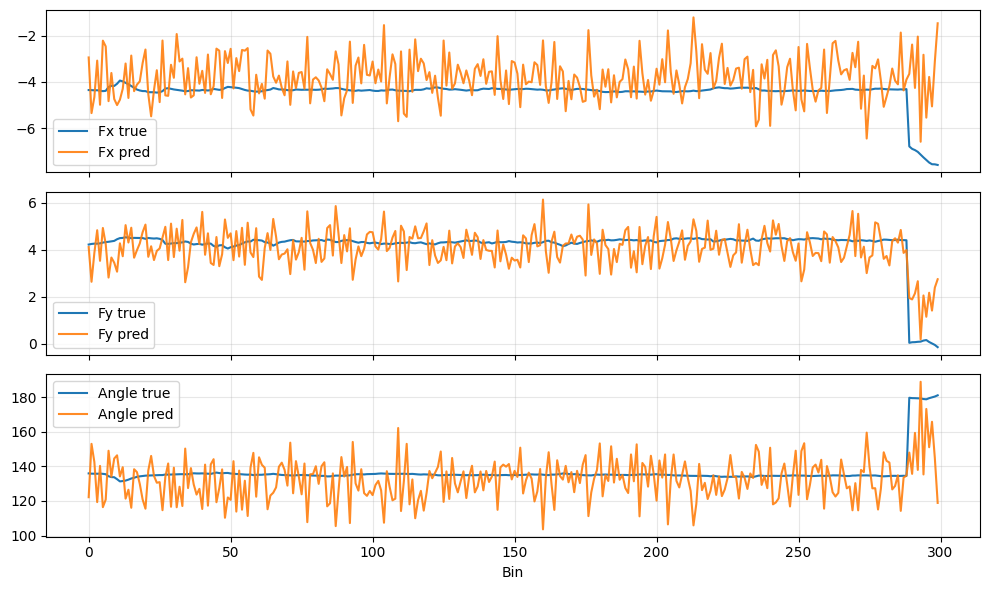

In [4]:

# Predict (model is a Pipeline with internal X scaler)
y_te_pred_norm = model.predict(X_te)

# Inverse-transform targets if we scaled during training
if y_scaler is not None:
    y_te_pred = y_scaler.inverse_transform(y_te_pred_norm)
else:
    y_te_pred = y_te_pred_norm

# Metrics
fx_mae = np.mean(np.abs(y_te_pred[:,0] - y_te[:,0]))
fy_mae = np.mean(np.abs(y_te_pred[:,1] - y_te[:,1]))
ang_true = y_te[:,2]
ang_pred = y_te_pred[:,2]
# if trained without angle as target, can derive angle instead:
# ang_true = np.degrees(np.arctan2(y_te[:,1], y_te[:,0]))
# ang_pred = np.degrees(np.arctan2(y_te_pred[:,1], y_te_pred[:,0]))
ang_err = (ang_pred - ang_true + 180) % 360 - 180
ang_mae = np.mean(np.abs(ang_err))

print(f"TEST MAE: Fx={fx_mae:.3f}, Fy={fy_mae:.3f}, Angle={ang_mae:.2f}°")

# Quick strip: first 300 bins
K = min(300, len(y_te))
t = np.arange(K)
fig, axes = plt.subplots(3,1, figsize=(10,6), sharex=True)
axes[0].plot(t, y_te[:K,0], label="Fx true"); axes[0].plot(t, y_te_pred[:K,0], label="Fx pred", alpha=0.9)
axes[0].legend(); axes[0].grid(alpha=0.3)
axes[1].plot(t, y_te[:K,1], label="Fy true"); axes[1].plot(t, y_te_pred[:K,1], label="Fy pred", alpha=0.9)
axes[1].legend(); axes[1].grid(alpha=0.3)
axes[2].plot(t, ang_true[:K], label="Angle true"); axes[2].plot(t, ang_pred[:K], label="Angle pred", alpha=0.9)
axes[2].legend(); axes[2].grid(alpha=0.3)
axes[2].set_xlabel("Bin")
plt.tight_layout()
plt.show()


In [5]:
# Map each test row to its nominal angle (from its group string)
nom_angles = np.array([nominal_from_group(g) for g in groups_te])

rows = []
for ang in sorted(np.unique(nom_angles)):
    mask = nom_angles == ang
    if mask.sum() == 0: 
        continue
    fx_mae_a = np.mean(np.abs(y_te_pred[mask,0] - y_te[mask,0]))
    fy_mae_a = np.mean(np.abs(y_te_pred[mask,1] - y_te[mask,1]))
    ang_true_a = y_te[mask,2]
    ang_pred_a = y_te_pred[mask,2]
    ang_err_a = (ang_pred_a - ang_true_a + 180) % 360 - 180
    ang_mae_a = np.mean(np.abs(ang_err_a))
    rows.append((ang, mask.sum(), fx_mae_a, fy_mae_a, ang_mae_a))


df_per_angle = pd.DataFrame(rows, columns=["angle_nom", "n_rows", "fx_mae", "fy_mae", "angle_mae_deg"])
df_per_angle


,angle_nom,n_rows,fx_mae,fy_mae,angle_mae_deg
0,90.0,292,1.787744,2.877413,28.194944
1,135.0,289,0.855352,0.586907,9.227768
2,180.0,295,3.346196,1.291041,25.354063


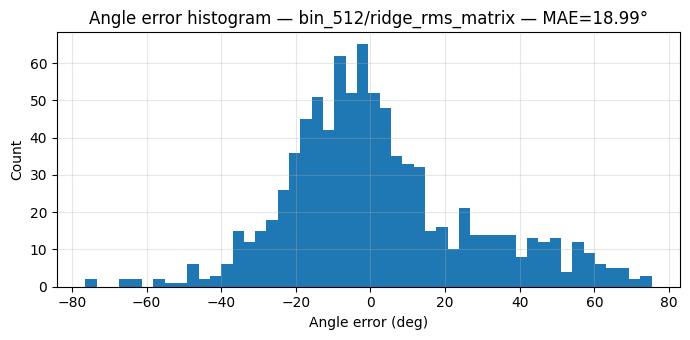

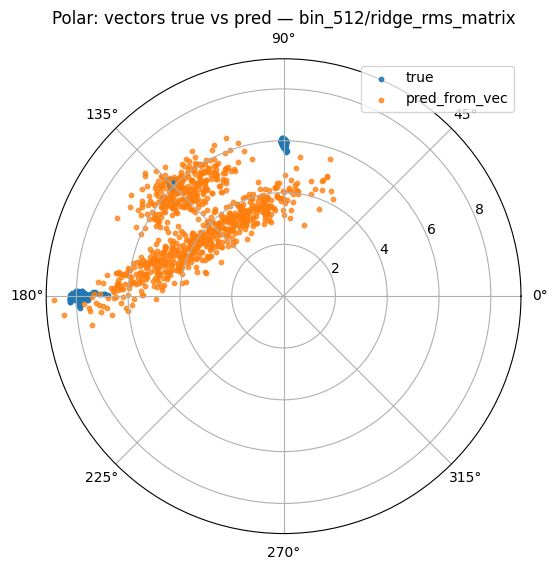

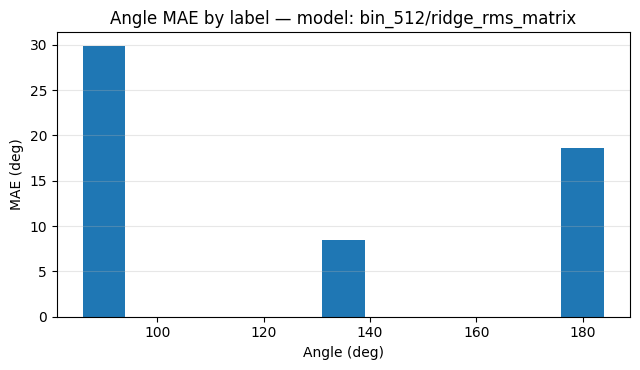

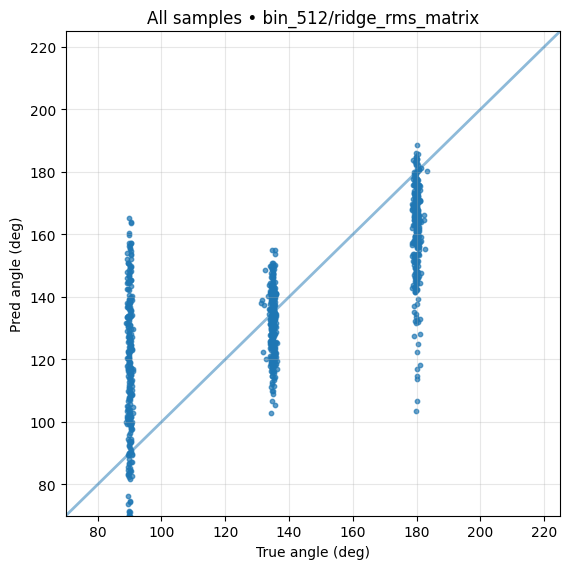

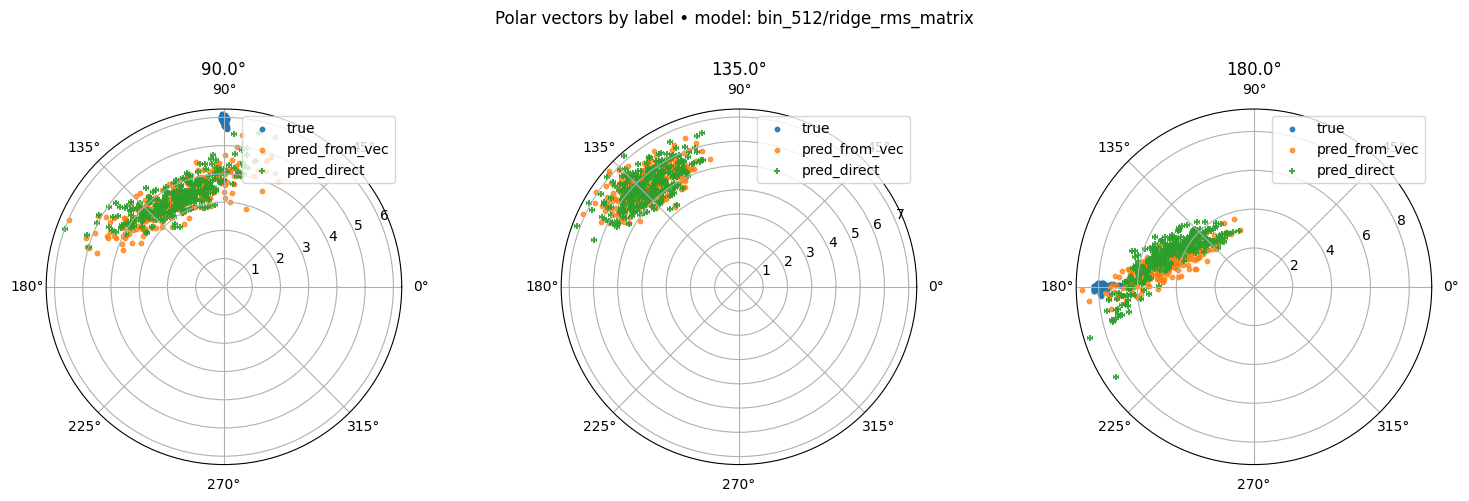

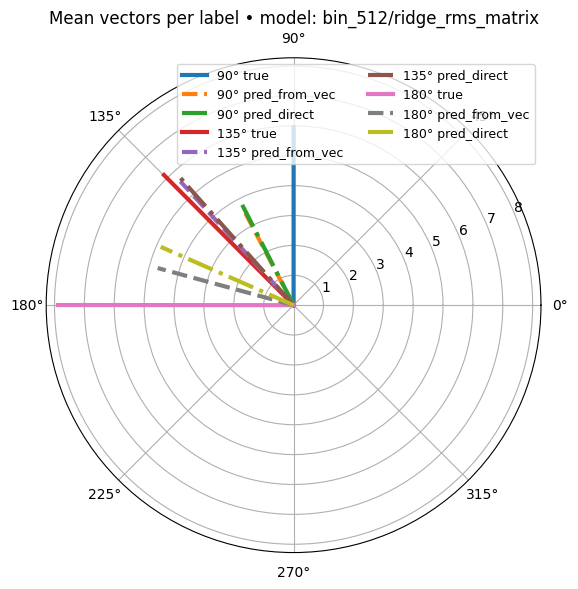

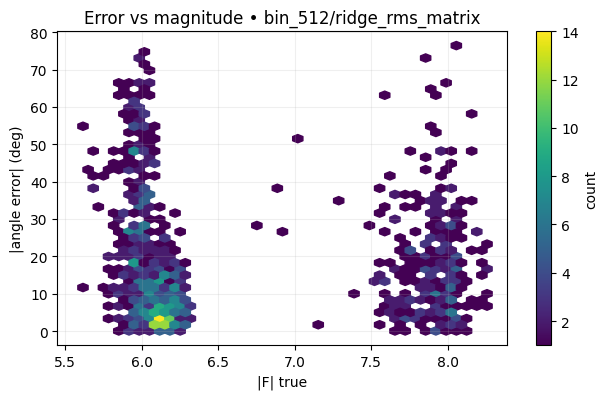

In [ ]:
pred_vec = y_te_pred[:, :2]                     # predicted Fx,Fy
pred_direct_deg = y_te_pred[:, 2] if y_te_pred.shape[1] >= 3 else None  # direct angle, if the model predicted it
y_true_vec = y_te[:, :2]                     # true Fx,Fy

# ---------- PLOT ----------
# uses your plotting helpers that accept the optional direct-angle overlay
full_plot_suite(
    y_true=y_true_vec,
    y_pred=pred_vec,
    labels_deg=nom_angles,
    model_name=f"{model_path.parent.name}/{model_path.stem}",
    pred_direct_deg=pred_direct_deg,     # overlay direct angle if available
)

### Backgenerating the Metrics.csv

In [11]:
# Run only once per Model

# ---------------- User-config ----------------
COMBINED_DIR = Path("data/preprocessing/P3_combined")   # *_combined.npy live here
RESULTS_ROOT = Path("results_feat/P3_ramp")            # bin_* folders + models
RMS_WIN      = 100                                      # must match training
RANDOM_STATE = 42

def _detect_fs_from_any_combined(combined_dir: Path) -> float:
    # Try meta.fs_force first; if missing, derive from first segment
    first = next(iter(_expand_combined_files(combined_dir)), None)
    if first is None:
        raise FileNotFoundError(f"No *_combined.npy under {combined_dir}")
    payload = np.load(first, allow_pickle=True).item()
    fs = payload.get("meta", {}).get("fs_force", None)
    if fs:
        return float(fs)
    # fallback via preprocess of first file
    pp = preprocess_plateaus(payload, rms_win_samples=RMS_WIN, modes=("rms_matrix",), keep_intended_angle=False)
    segs = pp.get("segments", [])
    if not segs:
        raise RuntimeError("Could not detect fs from first combined file (no segments).")
    return float(segs[0]["fs"])


# ---------- Model input shaping ----------
def _model_expected_n_features(model):
    # Try scaler first
    try:
        return int(model.named_steps["x_scaler"].n_features_in_)
    except Exception:
        pass
    # Then regressor
    try:
        return int(model.named_steps["reg"].n_features_in_)
    except Exception:
        pass
    return getattr(model, "n_features_in_", None)

def _get_selected_idx_if_available(model):
    # Common places people store indices/selectors
    for key in ("selector", "feature_selector", "colsel", "select_k_best"):
        if key in getattr(model, "named_steps", {}):
            sel = model.named_steps[key]
            if hasattr(sel, "get_support"):
                sup = sel.get_support()
                try:
                    return np.where(sup)[0]
                except Exception:
                    pass
            for attr in ("selected_idx", "support_"):
                if hasattr(sel, attr):
                    try:
                        return np.array(getattr(sel, attr), dtype=int)
                    except Exception:
                        pass
    for attr in ("selected_idx", "feature_idx", "channel_order"):
        if hasattr(model, attr):
            try:
                return np.array(getattr(model, attr), dtype=int)
            except Exception:
                pass
    return None

def _view_for_model_input(model_path: Path, model, X_full: np.ndarray) -> np.ndarray:
    name = model_path.name
    n_exp = _model_expected_n_features(model)
    idx = _get_selected_idx_if_available(model)
    if idx is not None:
        return X_full[:, idx]

    # Filename heuristics
    if "average_channels" in name:
        return X_full.mean(axis=1, keepdims=True)

    m = re.search(r"single_ch_(\d+)", name)
    if m:
        ch = max(0, min(int(m.group(1)), X_full.shape[1]-1))
        return X_full[:, [ch]]

    m = re.search(r"iterative_add_k(\d+)", name)
    if m:
        k = int(m.group(1))
        # You said k1 is first channel, etc. -> take first k columns
        return X_full[:, :k]

    # 'rms_matrix' / 'all_channels' models
    if ("all_channels" in name) or ("rms_matrix" in name):
        if n_exp and n_exp != X_full.shape[1]:
            return X_full[:, :n_exp]
        return X_full

    # Fallback: match expected dim if known
    if n_exp and n_exp != X_full.shape[1]:
        return X_full[:, :n_exp]
    return X_full

# ---------- Evaluation ----------# ---------- Evaluation (normalized + circular angle) ----------
def eval_models_in_bin(bin_dir: Path, X: np.ndarray, y: np.ndarray, groups: np.ndarray):
    def angular_diff_deg(y_true_deg, y_pred_deg):
        # shortest-arc difference in [-180, 180]
        return (y_pred_deg - y_true_deg + 180.0) % 360.0 - 180.0

    # Hold out one plateau per nominal angle
    train_idx, test_idx, test_groups = split_one_plateau_per_angle_test(groups, rng=RANDOM_STATE)
    X_tr, y_tr = X[train_idx], y[train_idx]
    X_te, y_te = X[test_idx], y[test_idx]

    # Normalization scales (from TRAIN set)
    # Use std for Fx/Fy; fixed 180° scale for angle
    eps = 1e-9
    scale_Fx = float(np.std(y_tr[:, 0]) + eps)
    scale_Fy = float(np.std(y_tr[:, 1]) + eps)
    scale_Ang = 180.0

    model_files = sorted(bin_dir.glob("ridge_*.joblib"))
    if not model_files:
        print(f"[WARN] {bin_dir.name}: no ridge_*.joblib models found.")
        return None

    y_scaler_path = bin_dir / "y_scaler.joblib"
    y_scaler = joblib.load(y_scaler_path) if y_scaler_path.exists() else None

    rows = []
    for mp in model_files:
        try:
            model = joblib.load(mp)
            X_view = _view_for_model_input(mp, model, X_te)
            y_pred = model.predict(X_view)

            # inverse-scale preds to original units if scaler exists
            if y_scaler is not None:
                try:
                    y_pred = y_scaler.inverse_transform(y_pred)
                except Exception as e:
                    print(f"[WARN] {mp.name}: y inverse_transform failed ({e}); using raw preds.")

            # RAW per-target metrics (for reference)
            Fx_mse = float(mean_squared_error(y_te[:, 0], y_pred[:, 0]))
            Fy_mse = float(mean_squared_error(y_te[:, 1], y_pred[:, 1]))
            Ang_mse_lin = float(mean_squared_error(y_te[:, 2], y_pred[:, 2]))

            Fx_mae = float(mean_absolute_error(y_te[:, 0], y_pred[:, 0]))
            Fy_mae = float(mean_absolute_error(y_te[:, 1], y_pred[:, 1]))
            Ang_mae_lin = float(mean_absolute_error(y_te[:, 2], y_pred[:, 2]))

            # Circular angle metrics
            ang_err = angular_diff_deg(y_te[:, 2], y_pred[:, 2])
            Ang_mae_circ = float(np.mean(np.abs(ang_err)))
            Ang_mse_circ = float(np.mean(ang_err ** 2))

            # Old overall MSE (unit-mixed, linear angle) for backward compatibility
            mse_raw_overall = float(np.mean([Fx_mse, Fy_mse, Ang_mse_lin]))

            # NORMALIZED metrics (unit-agnostic)
            Fx_mse_norm = float(np.mean(((y_te[:, 0] - y_pred[:, 0]) / scale_Fx) ** 2))
            Fy_mse_norm = float(np.mean(((y_te[:, 1] - y_pred[:, 1]) / scale_Fy) ** 2))
            Ang_mse_norm = float(np.mean((ang_err / scale_Ang) ** 2))

            Fx_mae_norm = float(np.mean(np.abs((y_te[:, 0] - y_pred[:, 0]) / scale_Fx)))
            Fy_mae_norm = float(np.mean(np.abs((y_te[:, 1] - y_pred[:, 1]) / scale_Fy)))
            Ang_mae_norm = float(np.mean(np.abs(ang_err / scale_Ang)))

            mse_norm_overall = float(np.mean([Fx_mse_norm, Fy_mse_norm, Ang_mse_norm]))
            mae_norm_overall = float(np.mean([Fx_mae_norm, Fy_mae_norm, Ang_mae_norm]))

            rows.append({
                "mode": mp.stem.replace("ridge_", ""),
                # ✅ normalized, unit-agnostic headline scores
                "mse_norm_overall": mse_norm_overall,
                "mae_norm_overall": mae_norm_overall,

                # 🔎 per-target normalized components (optional but handy)
                "mse_norm_Fx": Fx_mse_norm,
                "mse_norm_Fy": Fy_mse_norm,
                "mse_norm_Angle_circ": Ang_mse_norm,
                "mae_norm_Fx": Fx_mae_norm,
                "mae_norm_Fy": Fy_mae_norm,
                "mae_norm_Angle_circ": Ang_mae_norm,

                # 📏 raw per-target metrics in original units
                "mse_Fx": Fx_mse, "mse_Fy": Fy_mse, "mse_Angle_lin": Ang_mse_lin,
                "mae_Fx": Fx_mae, "mae_Fy": Fy_mae, "mae_Angle_lin": Ang_mae_lin,

                # 🔄 circular angle error in degrees
                "mae_Angle_circ": Ang_mae_circ,
                "mse_Angle_circ": Ang_mse_circ,

                # 🧾 keep old overall MSE (unit-mixed) for backward compatibility
                "mse_raw_overall": mse_raw_overall,

                # scales used (so results are reproducible)
                "scale_Fx": scale_Fx,
                "scale_Fy": scale_Fy,
                "scale_Ang": scale_Ang,
            })
        except Exception as e:
            print(f"[WARN] {bin_dir.name}: failed evaluating {mp.name}: {e}")

    if not rows:
        return None

    out_csv = bin_dir / "cv_metrics_test.csv"
    pd.DataFrame(rows).to_csv(out_csv, index=False)
    print(f"[SAVE] {out_csv}  ({len(rows)} models)")
    return out_csv

def main():
    # Optional: detect and log sampling rate from any combined file
    try:
        fs = _detect_fs_from_any_combined(COMBINED_DIR)
        print(f"[INFO] detected fs ≈ {fs:.3f} Hz")
    except Exception as e:
        print(f"[WARN] could not detect fs ({e}); continuing.")

    # Find all bin_* result folders
    if not RESULTS_ROOT.exists():
        raise SystemExit(f"[ERR] RESULTS_ROOT not found: {RESULTS_ROOT}")
    bin_dirs = sorted(p for p in RESULTS_ROOT.iterdir() if p.is_dir() and p.name.startswith("bin_"))
    if not bin_dirs:
        raise SystemExit(f"[ERR] No bin_* folders under {RESULTS_ROOT}")

    for bdir in bin_dirs:
        # Parse bin length (samples) from folder name
        try:
            bin_len = int(bdir.name.split("_")[-1])
        except Exception:
            print(f"[SKIP] {bdir.name}: cannot parse bin length")
            continue

        # Build dataset for this exact bin length
        X, y, groups, _angles = collect_dataset_from_combined(
            COMBINED_DIR,
            bin_len_samples=bin_len,
            include_angle_target=True,
            rms_win_samples=RMS_WIN,
            modes=("rms_matrix",),
        )
        if X.size == 0:
            print(f"[SKIP] {bdir.name}: empty X/y after loading.")
            continue

        print(f"[RUN] {bdir.name}: X={X.shape}, y={y.shape}, groups={len(np.unique(groups))}")
        # Evaluate all models in this bin folder and save cv_metrics_test.csv
        out_csv = eval_models_in_bin(bdir, X, y, groups)
        if out_csv is None:
            print(f"[WARN] {bdir.name}: no metrics written.")


# Bin Size over model compared

### Analysis and Plots

In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def bin_size_model_summary(
    results_base: Path,
    metric_col: str = "mae_Angle_circ",   # or "mae_norm_overall", "mse_norm_overall", ...
    out_png: Path | None = None,
    out_csv: Path | None = None,
    verbose: bool = True,
):
    """
    Summarize 'metric_col' vs bin size across models found under results_base/bin_*.
    Returns a dict with df_plot, summary, best_combo_label, selected_k (if fixed), and paths.

    Expects each bin_* folder to contain a CSV with 'mode' and metric columns, and uses:
      - average_channels
      - rms_matrix
      - iterative_add_kN (extract N)
    """
    # ---- defaults for outputs
    if out_png is None:
        out_png = results_base / f"summary_{metric_col}.png"
    if out_csv is None:
        out_csv = results_base / f"summary_{metric_col}.csv"

    # ---- discover bin_* dirs
    bin_dirs = _find_bin_dirs(results_base)
    if not bin_dirs:
        raise SystemExit(f"No bin_* folders found under {results_base}")

    records = []
    iter_by_bin: dict[int, pd.DataFrame] = {}

    # ---- collect per-bin metrics
    for bs, bdir in bin_dirs.items():
        df = _load_metrics_for_bin(bdir, metric_col=metric_col)

        # 1) average_channels
        sub = df[df["mode"] == "average_channels"]
        if not sub.empty:
            v = float(sub[metric_col].iloc[0])
            records.append({"bin_size": bs, "model": "avg_all_channels", metric_col: v})
        elif verbose:
            print(f"[WARN] bin={bs}: no 'average_channels' row")

        # 2) rms_matrix
        sub = df[df["mode"] == "rms_matrix"]
        if not sub.empty:
            v = float(sub[metric_col].iloc[0])
            records.append({"bin_size": bs, "model": "all_channels_features", metric_col: v})
        elif verbose:
            print(f"[WARN] bin={bs}: no 'rms_matrix' row")

        # 3) iterative_add_kN
        df_it = df[df["mode"].str.contains(r"^iterative_add_k\d+$", regex=True)].copy()
        if df_it.empty:
            if verbose:
                print(f"[WARN] bin={bs}: no 'iterative_add_k*' rows")
            iter_by_bin[bs] = pd.DataFrame(columns=["k_channels", metric_col])
        else:
            df_it["k_channels"] = df_it["mode"].str.extract(r"k(\d+)").astype(int)
            iter_by_bin[bs] = df_it[["k_channels", metric_col]].copy()

            # also record k=3 for side-by-side comparison
            hit = df_it[df_it["k_channels"] == 3]
            v = float(hit[metric_col].iloc[0]) if not hit.empty else np.nan
            records.append({"bin_size": bs, "model": "k3_combo", metric_col: v})

    # ---- choose best combo: fixed k across bins if possible, else per-bin best
    sets_of_k = [set(df_it["k_channels"].tolist()) for df_it in iter_by_bin.values() if not df_it.empty]
    common_k = set.intersection(*sets_of_k) if sets_of_k else set()

    if common_k:
        # pick k that minimizes average metric across bins
        k_candidates = sorted(common_k)
        avg_vals = []
        for k in k_candidates:
            vals = []
            for bs, df_it in iter_by_bin.items():
                v = df_it.loc[df_it["k_channels"] == k, metric_col]
                if not v.empty:
                    vals.append(float(v.iloc[0]))
            if vals:
                avg_vals.append((k, float(np.mean(vals))))
        selected_k = sorted(avg_vals, key=lambda t: t[1])[0][0]
        best_combo_label = f"best_combo (k={selected_k})"
        for bs, df_it in iter_by_bin.items():
            v = df_it.loc[df_it["k_channels"] == selected_k, metric_col]
            val = float(v.iloc[0]) if not v.empty else np.nan
            records.append({"bin_size": bs, "model": best_combo_label, metric_col: val, "k": selected_k})
    else:
        selected_k = None
        best_combo_label = "best_combo (per-bin k)"
        for bs, df_it in iter_by_bin.items():
            if df_it.empty:
                records.append({"bin_size": bs, "model": best_combo_label, metric_col: np.nan, "k": np.nan})
                continue
            row = df_it.sort_values(metric_col, ascending=True).iloc[0]
            records.append({"bin_size": bs, "model": best_combo_label, metric_col: float(row[metric_col]), "k": int(row["k_channels"])})

    # ---- build table
    df_plot = pd.DataFrame(records)
    summary = (
        df_plot.pivot_table(index="bin_size", columns="model", values=metric_col, aggfunc="first")
               .sort_index()
    )
    results_base.mkdir(parents=True, exist_ok=True)
    summary.to_csv(out_csv)
    if verbose:
        print(f"[SAVE] {out_csv}")

    # ---- plot
    plt.figure(figsize=(7.5, 4.2))
    bin_sizes_sorted = sorted(bin_dirs.keys())

    def _line(col_key: str, label: str):
        if col_key in summary:
            y = summary[col_key].reindex(bin_sizes_sorted)
            plt.plot(bin_sizes_sorted, y, marker="o", label=label)
        elif verbose:
            print(f"[WARN] column '{col_key}' not in summary")

    ylabel = "Normalized MSE" if metric_col.startswith("mse") else "Normalized MAE"

    _line("avg_all_channels", "avg all channels")
    _line("all_channels_features", "all channels (features)")
    _line(best_combo_label, best_combo_label)
    _line("k3_combo", "best 3 channel combo (k=3)")

    plt.xlabel("Bin size (samples)")
    plt.ylabel(ylabel + " ↓")
    plt.title(f"{ylabel} vs Bin size by model — {results_base.name}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()
    if verbose:
        print(f"[PLOT] {out_png}")

    # ---- annotate selection
    if verbose:
        if selected_k is None:
            sub = df_plot[df_plot["model"] == best_combo_label]
            ks = {int(r.bin_size): int(r.k) for r in sub.itertuples() if pd.notna(r.k)}
            print("\nChosen k per bin for 'best_combo (per-bin k)':")
            for bs in bin_sizes_sorted:
                print(f"  bin {bs}: k={ks.get(bs, 'NA')}")
        else:
            print(f"\nSelected common k for 'best combo': k={selected_k}")

    return {
        "df_plot": df_plot,
        "summary": summary,
        "best_combo_label": best_combo_label,
        "selected_k": selected_k,
        "out_png": out_png,
        "out_csv": out_csv,
    }


[SAVE] results_feat/P3_angle/summary_mae_Angle_circ.csv


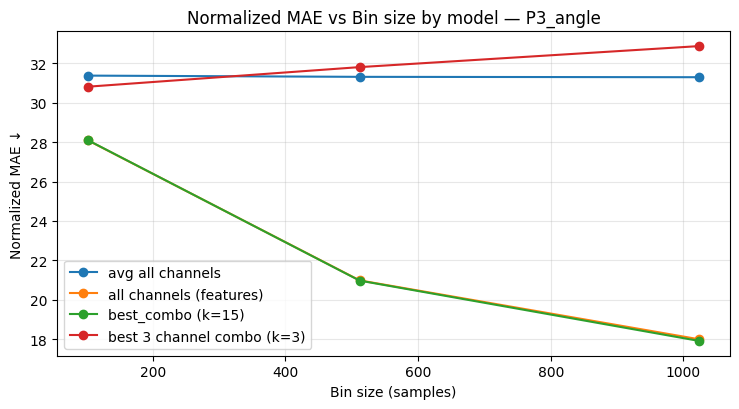

[PLOT] results_feat/P3_angle/summary_mae_Angle_circ.png

Selected common k for 'best combo': k=15
[SAVE] results_feat/P5_angle/summary_mae_Angle_circ.csv


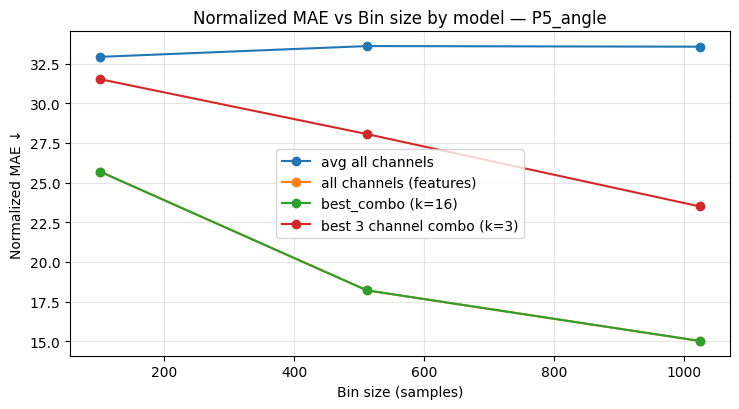

[PLOT] results_feat/P5_angle/summary_mae_Angle_circ.png

Selected common k for 'best combo': k=16
[SAVE] results_feat/P3_angle/summary_mse_norm_overall.csv


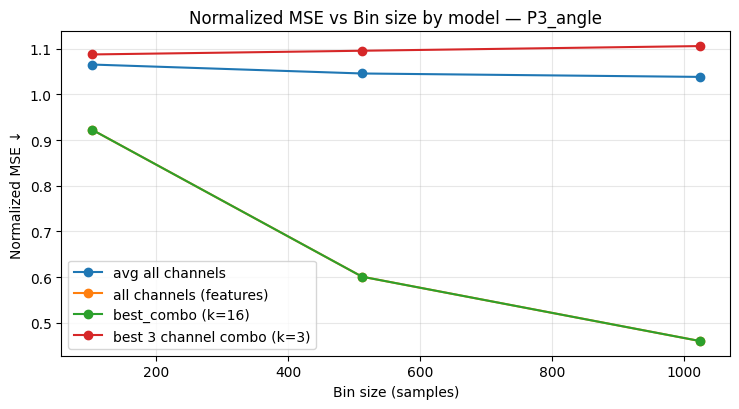

[PLOT] results_feat/P3_angle/summary_mse_norm_overall.png

Selected common k for 'best combo': k=16


{'df_plot':     bin_size                  model  mse_norm_overall     k
 0        102       avg_all_channels          1.065405   NaN
 1        102  all_channels_features          0.923061   NaN
 2        102               k3_combo          1.087465   NaN
 3        512       avg_all_channels          1.045800   NaN
 4        512  all_channels_features          0.601048   NaN
 5        512               k3_combo          1.095576   NaN
 6       1024       avg_all_channels          1.038344   NaN
 7       1024  all_channels_features          0.460335   NaN
 8       1024               k3_combo          1.105789   NaN
 9        102      best_combo (k=16)          0.923061  16.0
 10       512      best_combo (k=16)          0.601048  16.0
 11      1024      best_combo (k=16)          0.460335  16.0,
 'summary': model     all_channels_features  avg_all_channels  best_combo (k=16)  k3_combo
 bin_size                                                                      
 102                    

In [6]:
# P3 angle
bin_size_model_summary(Path("./results_feat/P3_angle"), metric_col="mae_Angle_circ")

# P5 angle
bin_size_model_summary(Path("./results_feat/P5_angle"), metric_col="mae_Angle_circ")

# If you want MSE-normalized instead:
bin_size_model_summary(Path("./results_feat/P3_angle"), metric_col="mse_norm_overall")


### Feature Correlations

In [12]:

def _safe_pearsonr(x, y):
    x = np.asarray(x, float).ravel()
    y = np.asarray(y, float).ravel()
    sx, sy = np.std(x), np.std(y)
    if sx == 0 or sy == 0 or len(x) < 2:
        return np.nan
    # np.corrcoef handles NaNs poorly; drop if present
    m = np.isfinite(x) & np.isfinite(y)
    if m.sum() < 2:
        return np.nan
    return float(np.corrcoef(x[m], y[m])[0, 1])

def _angle_circular_linear_r(feature, angle_deg):
    """
    Circular-linear association (quick + robust):
    compute Pearson r(feature, sin(angle)) and r(feature, cos(angle)),
    then take resultant magnitude sqrt(r_sin^2 + r_cos^2) in [0,1].
    """
    ang = np.deg2rad(np.asarray(angle_deg, float).ravel())
    s = np.sin(ang)
    c = np.cos(ang)
    r_s = _safe_pearsonr(feature, s)
    r_c = _safe_pearsonr(feature, c)
    if np.isnan(r_s) or np.isnan(r_c):
        return np.nan
    return float(np.sqrt(r_s**2 + r_c**2))

def compute_test_correlations_for_bin(combined_dir, results_root, bin_len, rng=42, channel_names=None):
    """
    Builds X, y, groups for the given bin_len (samples), splits into train/test using your
    one-plateau-per-angle strategy, and computes feature-target correlations on the TEST set.
    Returns (corr_df, save_dir) and also writes CSV/PNG into the bin folder.
    """
    combined_dir = Path(combined_dir)
    results_root = Path(results_root)
    bin_dir = results_root / f"bin_{bin_len}"
    assert bin_dir.is_dir(), f"Missing folder: {bin_dir}"

    # Build the dataset exactly like during training/eval
    X, y, groups, _ = collect_dataset_from_combined(
        combined_dir,
        bin_len_samples=bin_len,
        include_angle_target=True,
        rms_win_samples=RMS_WIN,
        modes=("rms_matrix",),
    )
    assert X.size, "Empty X."
    _, test_idx, test_groups = split_one_plateau_per_angle_test(groups, rng=rng)
    X_te, y_te = X[test_idx], y[test_idx]

    # Labels
    if channel_names is None:
        feature_names = [f"ch{i}" for i in range(X_te.shape[1])]
    else:
        assert len(channel_names) == X_te.shape[1], "channel_names length must match X columns"
        feature_names = list(channel_names)
    target_names = ["Fx", "Fy", "Angle"]

    # Correlations
    r_lin = np.zeros((X_te.shape[1], 3)) * np.nan
    r_circ = np.zeros((X_te.shape[1],)) * np.nan

    for i in range(X_te.shape[1]):
        r_lin[i, 0] = _safe_pearsonr(X_te[:, i], y_te[:, 0])  # Fx
        r_lin[i, 1] = _safe_pearsonr(X_te[:, i], y_te[:, 1])  # Fy
        r_lin[i, 2] = _safe_pearsonr(X_te[:, i], y_te[:, 2])  # Angle (linear Pearson, less ideal)
        r_circ[i]   = _angle_circular_linear_r(X_te[:, i], y_te[:, 2])  # Angle (circular-linear magnitude)

    corr_df = pd.DataFrame(
        np.column_stack([r_lin, r_circ]),
        index=feature_names,
        columns=["r_Fx", "r_Fy", "r_Angle_lin", "r_Angle_circ_mag"]
    )

    # Save CSV
    out_csv = bin_dir / "feature_target_correlations_TEST.csv"
    corr_df.to_csv(out_csv)
    print(f"[SAVE] {out_csv}")

    # Plot heatmaps (matplotlib only)
    # 1) Fx/Fy linear r
    fig1 = plt.figure(figsize=(6, 4))
    ax1 = fig1.add_subplot(111)
    mat = np.column_stack([corr_df["r_Fx"].values, corr_df["r_Fy"].values])
    im = ax1.imshow(mat, aspect="auto", origin="upper", vmin=-1, vmax=1)
    ax1.set_yticks(range(len(feature_names))); ax1.set_yticklabels(feature_names)
    ax1.set_xticks([0,1]); ax1.set_xticklabels(["Fx", "Fy"])
    ax1.set_title("Feature–Target Pearson r (TEST): Fx/Fy")
    fig1.colorbar(im, ax=ax1, label="r")
    fig1.tight_layout()
    out_png1 = bin_dir / "feature_target_corr_TEST_FxFy.png"
    fig1.savefig(out_png1, dpi=150); plt.show()
    print(f"[PLOT] {out_png1}")

    # 2) Angle: show linear r and circular magnitude side-by-side
    fig2 = plt.figure(figsize=(7.2, 4))
    ax2 = fig2.add_subplot(111)
    mat2 = np.column_stack([corr_df["r_Angle_lin"].values, corr_df["r_Angle_circ_mag"].values])
    im2 = ax2.imshow(mat2, aspect="auto", origin="upper", vmin=0 if np.nanmin(mat2)>0 else -1, vmax=1)
    ax2.set_yticks(range(len(feature_names))); ax2.set_yticklabels(feature_names)
    ax2.set_xticks([0,1]); ax2.set_xticklabels(["Angle (linear r)", "Angle (circular |r|)"])
    ax2.set_title("Feature–Angle Association (TEST)")
    fig2.colorbar(im2, ax=ax2, label="r or |r|")
    fig2.tight_layout()
    out_png2 = bin_dir / "feature_target_corr_TEST_Angle.png"
    fig2.savefig(out_png2, dpi=150); plt.show()
    print(f"[PLOT] {out_png2}")

    return corr_df, bin_dir
 

[LOAD] bin_len=1024: X=(3211, 16), y=(3211, 3), groups=22
[SAVE] results_feat/P3_ramp/bin_1024/feature_target_correlations_TEST.csv


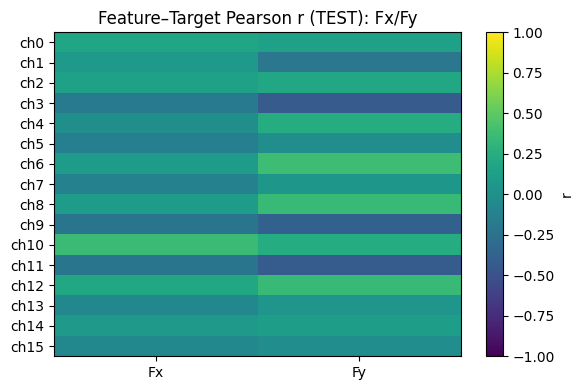

[PLOT] results_feat/P3_ramp/bin_1024/feature_target_corr_TEST_FxFy.png


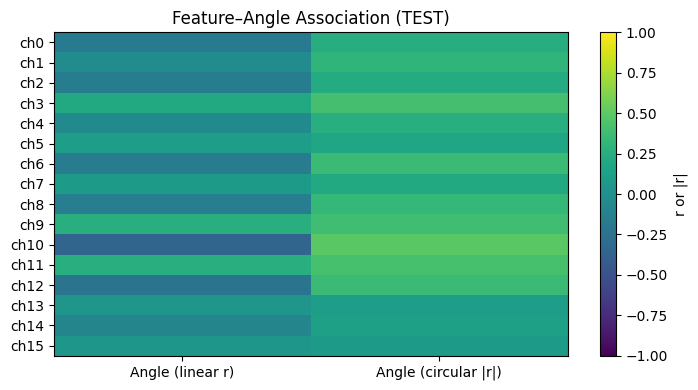

[PLOT] results_feat/P3_ramp/bin_1024/feature_target_corr_TEST_Angle.png


,r_Fx,r_Fy,r_Angle_lin,r_Angle_circ_mag
ch10,0.362356,0.235387,-0.344435,0.489858
ch11,-0.221898,-0.420669,0.260943,0.419529
ch3,-0.166935,-0.426911,0.215012,0.407727
ch9,-0.222029,-0.378478,0.252108,0.388172
ch12,0.196123,0.358467,-0.230495,0.362186


In [13]:
COMBINED_DIR = "data/preprocessing/P3_combined"
RESULTS_ROOT = "results_feat/P3_ramp"
BIN_LEN = 1024   # or 1024, etc.

corr_df, _ = compute_test_correlations_for_bin(COMBINED_DIR, RESULTS_ROOT, BIN_LEN, rng=RANDOM_STATE)
corr_df.sort_values("r_Angle_circ_mag", ascending=False).head()


[LOAD] bin_len=1024: X=(3211, 16), y=(3211, 3), groups=22
[SAVE] results_feat/P3_angle/bin_1024/feature_target_correlations_TEST.csv


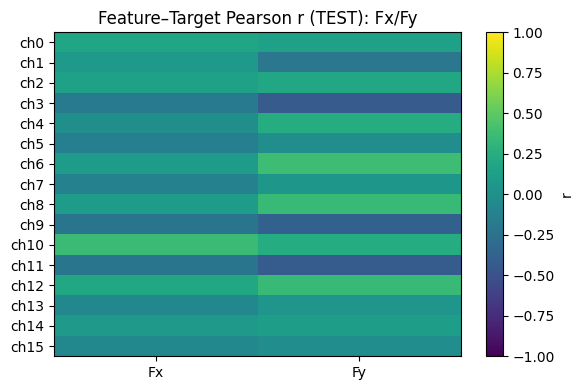

[PLOT] results_feat/P3_angle/bin_1024/feature_target_corr_TEST_FxFy.png


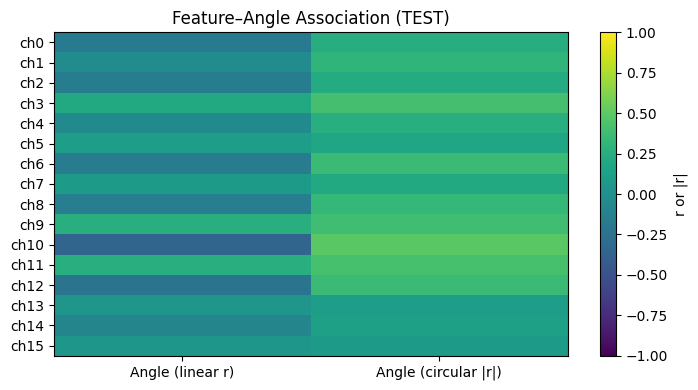

[PLOT] results_feat/P3_angle/bin_1024/feature_target_corr_TEST_Angle.png


,r_Fx,r_Fy,r_Angle_lin,r_Angle_circ_mag
ch10,0.362356,0.235387,-0.344435,0.489858
ch11,-0.221898,-0.420669,0.260943,0.419529
ch3,-0.166935,-0.426911,0.215012,0.407727
ch9,-0.222029,-0.378478,0.252108,0.388172
ch12,0.196123,0.358467,-0.230495,0.362186


In [14]:
COMBINED_DIR = "data/preprocessing/P3_combined"
RESULTS_ROOT = "results_feat/P3_angle"
BIN_LEN = 1024

corr_df, _ = compute_test_correlations_for_bin(COMBINED_DIR, RESULTS_ROOT, BIN_LEN, rng=RANDOM_STATE)
corr_df.sort_values("r_Angle_circ_mag", ascending=False).head()


[LOAD] bin_len=1024: X=(1688, 16), y=(1688, 3), groups=12
[SAVE] results_feat/P5_ramp/bin_1024/feature_target_correlations_TEST.csv


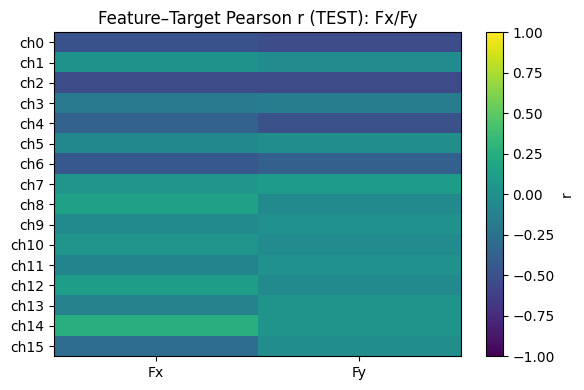

[PLOT] results_feat/P5_ramp/bin_1024/feature_target_corr_TEST_FxFy.png


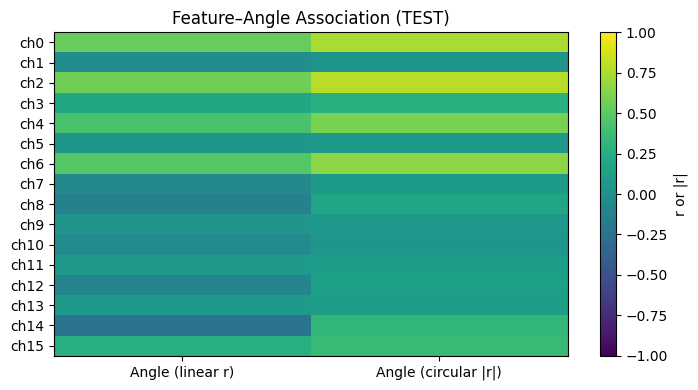

[PLOT] results_feat/P5_ramp/bin_1024/feature_target_corr_TEST_Angle.png


,r_Fx,r_Fy,r_Angle_lin,r_Angle_circ_mag
ch2,-0.528723,-0.541130,0.569694,0.787585
ch0,-0.495118,-0.524263,0.537233,0.743352
ch6,-0.452235,-0.386346,0.471061,0.649545
ch4,-0.372219,-0.501557,0.425502,0.594618
ch15,-0.287440,-0.009801,0.250969,0.353516


In [15]:
COMBINED_DIR = "data/preprocessing/P5_combined"
RESULTS_ROOT = "results_feat/P5_ramp"
BIN_LEN = 1024

corr_df, _ = compute_test_correlations_for_bin(COMBINED_DIR, RESULTS_ROOT, BIN_LEN, rng=RANDOM_STATE)
corr_df.sort_values("r_Angle_circ_mag", ascending=False).head()


[LOAD] bin_len=1024: X=(1688, 16), y=(1688, 3), groups=12
[SAVE] results_feat/P5_angle/bin_1024/feature_target_correlations_TEST.csv


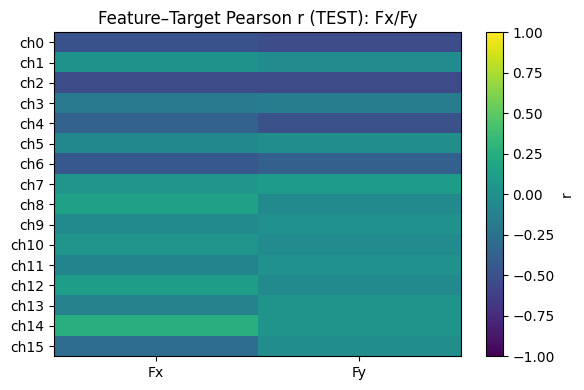

[PLOT] results_feat/P5_angle/bin_1024/feature_target_corr_TEST_FxFy.png


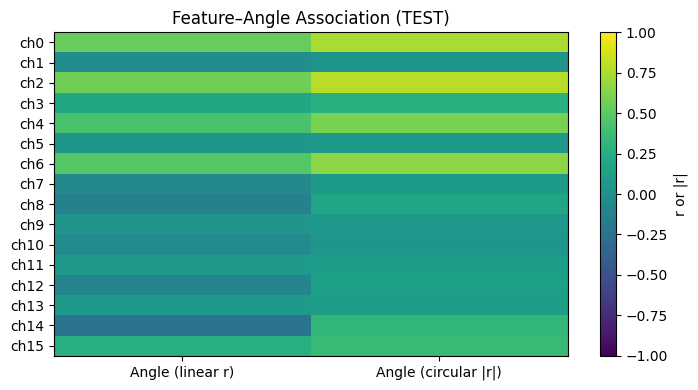

[PLOT] results_feat/P5_angle/bin_1024/feature_target_corr_TEST_Angle.png


,r_Fx,r_Fy,r_Angle_lin,r_Angle_circ_mag
ch2,-0.528723,-0.541130,0.569694,0.787585
ch0,-0.495118,-0.524263,0.537233,0.743352
ch6,-0.452235,-0.386346,0.471061,0.649545
ch4,-0.372219,-0.501557,0.425502,0.594618
ch15,-0.287440,-0.009801,0.250969,0.353516


In [16]:
COMBINED_DIR = "data/preprocessing/P5_combined"
RESULTS_ROOT = "results_feat/P5_angle"
BIN_LEN = 1024

corr_df, _ = compute_test_correlations_for_bin(COMBINED_DIR, RESULTS_ROOT, BIN_LEN, rng=RANDOM_STATE)
corr_df.sort_values("r_Angle_circ_mag", ascending=False).head()
